In [ ]:
%load_ext rpy2.ipython 

# Load information

In [ ]:
%%capture
%%R

install.packages("data.table")
#install.packages("quantreg")

library(data.table)
library(tidyverse)
library(scales)


In [ ]:
%%capture
%%R
#install.packages("gamboostLSS")
#library(gamboostLSS)
install.packages("corrplot") 
library(corrplot)
install.packages("Hmisc")
library("Hmisc")

In [ ]:
%%capture
%%R

install.packages("caret")
library(caret)
install.packages("glmnet")
library(glmnet)

In [ ]:
%%R
posts_data <- data.table()
posts_file <- "all_posts.csv"
last_file <- ""
load_initial_data <- function(initial_date,final_date, country_to_filter){
  if((dim(posts_data)[1] == 0) | last_file != posts_file){
      
  view_party <- read.csv("view_party.csv", encoding="UTF8")

  view_party_data <- view_party %>% filter(!is.na(facebook_id))
  all_posts_collected_utf.8 <<- read.csv(posts_file, encoding="UTF8")
  if(!missing(country_to_filter)){
      view_party_data <- view_party_data %>% filter(country_name==country_to_filter)
  }

  view_party_data <<- view_party_data
  posts_data <<- all_posts_collected_utf.8 %>% filter(page_id %in% c(view_party_data$facebook_id))


  for(id in view_party_data$facebook_id){
    if(!is.na(view_party_data$left_right[view_party_data$facebook_id==id])){
      posts_data$ideology[posts_data$page_id==id] <- switch(round(view_party_data$left_right[view_party_data$facebook_id==id])+1, "far-left", "far-left", "left", "left", "center", "center", "center", "right", "right", "far-right", "far-right")
    }else{
      posts_data$ideology[posts_data$page_id==id] <- NA
    }
    posts_data$left_right[posts_data$page_id==id] <- view_party_data$left_right[view_party_data$facebook_id==id]
    posts_data$country_name[posts_data$page_id==id] <- view_party_data$country_name[view_party_data$facebook_id==id]
    posts_data$family_name[posts_data$page_id==id] <- view_party_data$family_name[view_party_data$facebook_id==id]
    posts_data$party_name[posts_data$page_id==id] <- view_party_data$party_name[view_party_data$facebook_id==id]
    posts_data$party_name_short[posts_data$page_id==id] <- view_party_data$party_name_short[view_party_data$facebook_id==id]
    posts_data$party_id[posts_data$page_id==id] <- view_party_data$party_id[view_party_data$facebook_id==id]

    #posts_data$page_id[posts_data$page_id==id] <- paste(view_party_data$country_name_short[view_party_data$facebook_id==id], view_party_data$party_name_short[view_party_data$facebook_id==id], sep = ": ") 

  }

  dates <- strsplit(as.character(posts_data$timestamp), split=" ")
  sep<- sapply(dates, "[", 1)

  month <- format(as.Date(sep, format="%Y-%m-%d"), format = "%Y/%m")
  week <- format(as.Date(sep, format="%Y-%m-%d"), format = "%Y/%U")
  for(w in seq(week)){
	  p <- str_split(week[w], "/")
		if(p[[1]][2] == "00"){
			week[w] = paste(strtoi(p[[1]][1])-1, 52, sep="/")
		}
	}
  last_file <<- posts_file
  week <- as.Date(paste(week, "1", sep = "/"), format = "%Y/%U/%w")


  posts_data <- posts_data %>% add_column(month, .before = "comments")
  posts_data <- posts_data %>% add_column(week, .before = "month")

  posts_data$week[posts_data$month=="2019/01" & is.na(posts_data$week)] <<- as.Date("2018-12-31", format="%Y-%m-%d")
  posts_data$week[posts_data$month=="2020/01" & is.na(posts_data$week)] <<- as.Date("2019-12-30", format="%Y-%m-%d")

  #posts_data <- posts_data %>% union( posts_data %>% filter(party_name=="Sinn Féin") %>% mutate(ideology="far-left", left_right=1.3, country_name = "United Kingdom")   )

  posts_data <<- posts_data

  #TODO: Remove filters)
  }
  posts_data_act <- data.table(posts_data)

  if(!missing(country_to_filter)){
      posts_data_act <- posts_data_act %>% filter(country_name==country_to_filter)
  }
  print(paste("Total posts wihtout filters:", length(posts_data_act$comments)))
  posts_data_act <- posts_data_act  %>% filter(as.Date(timestamp) < as.Date(final_date)) %>% filter(as.Date(timestamp) > as.Date(initial_date))
  print(paste("Total posts with date filters:", length(posts_data_act$comments)))

  posts_data <<- posts_data
  posts_data_act <<- posts_data_act
  countries <<- unique(posts_data$country_name)
}

load_initial_data("2018-12-31", "2022-01-01")

[1] "Total posts wihtout filters: 597200"
[1] "Total posts with date filters: 550368"


In [ ]:
%%R 
cn = unique(posts_data$country_name)
eu_ideologies = data.table("country_name" = cn, "max" = 0.0, "min" = 0.0, "center" = 0.0)

for(c in cn){
    ideologies <- unique((posts_data
 %>% filter(country_name==c) %>% filter(!is.na(left_right)) )$left_right) 
    
    for(i in ideologies){

        if(eu_ideologies[country_name==c]$max < i){
            eu_ideologies[country_name==c]$max <- i
        }
        if(eu_ideologies[country_name==c]$min == 0 ||eu_ideologies[country_name==c]$min > i){
            eu_ideologies[country_name==c]$min <- i
        }
    }

    eu_ideologies[country_name==c]$center <- eu_ideologies[country_name==c]$min + (eu_ideologies[country_name==c]$max - eu_ideologies[country_name==c]$min)/2 
}
eu_ideologies <- eu_ideologies[order(eu_ideologies$min),]
print(eu_ideologies[order(eu_ideologies$min),])

      country_name    max    min  center
 1:     Luxembourg 8.8158 0.5263 4.67105
 2: Czech Republic 8.8000 0.7498 4.77490
 3:        Denmark 8.2269 0.8912 4.55905
 4:         Cyprus 8.8000 1.0526 4.92630
 5:        Germany 8.8000 1.2152 5.00760
 6:       Slovenia 7.9345 1.3000 4.61725
 7:        Belgium 9.6622 1.3000 5.48110
 8:          Spain 8.8000 1.3000 5.05000
 9:         France 9.6854 1.3000 5.49270
10:          Italy 7.8007 1.3000 4.55035
11:        Ireland 7.4000 1.3000 4.35000
12:         Greece 8.8000 1.3000 5.05000
13:    Netherlands 8.8000 1.3682 5.08410
14:         Sweden 8.8000 1.5464 5.17320
15:       Portugal 8.0222 1.6425 4.83235
16:        Croatia 8.8000 1.8421 5.32105
17:         Latvia 8.8000 1.8640 5.33200
18:        Finland 8.8000 2.1843 5.49215
19:        Austria 8.3494 2.4604 5.40490
20:      Lithuania 7.7562 2.5000 5.12810
21:        Estonia 8.4962 2.5000 5.49810
22: United Kingdom 8.8000 2.5700 5.68500
23:         Poland 8.8000 2.8299 5.81495
24:        Hunga

[1] 8.8
[1] 7.4
[1] 6
[1] 7.4
[1] 8.8
[1] 6
[1] 6.021
[1] 6
[1] 7.4
[1] 7.4
[1] 7.421
[1] 8.8
[1] 6
[1] 6
[1] 6.021
[1] 3.3
[1] 3.3
[1] 3.321
[1] 6
[1] 1.3
[1] 7.4


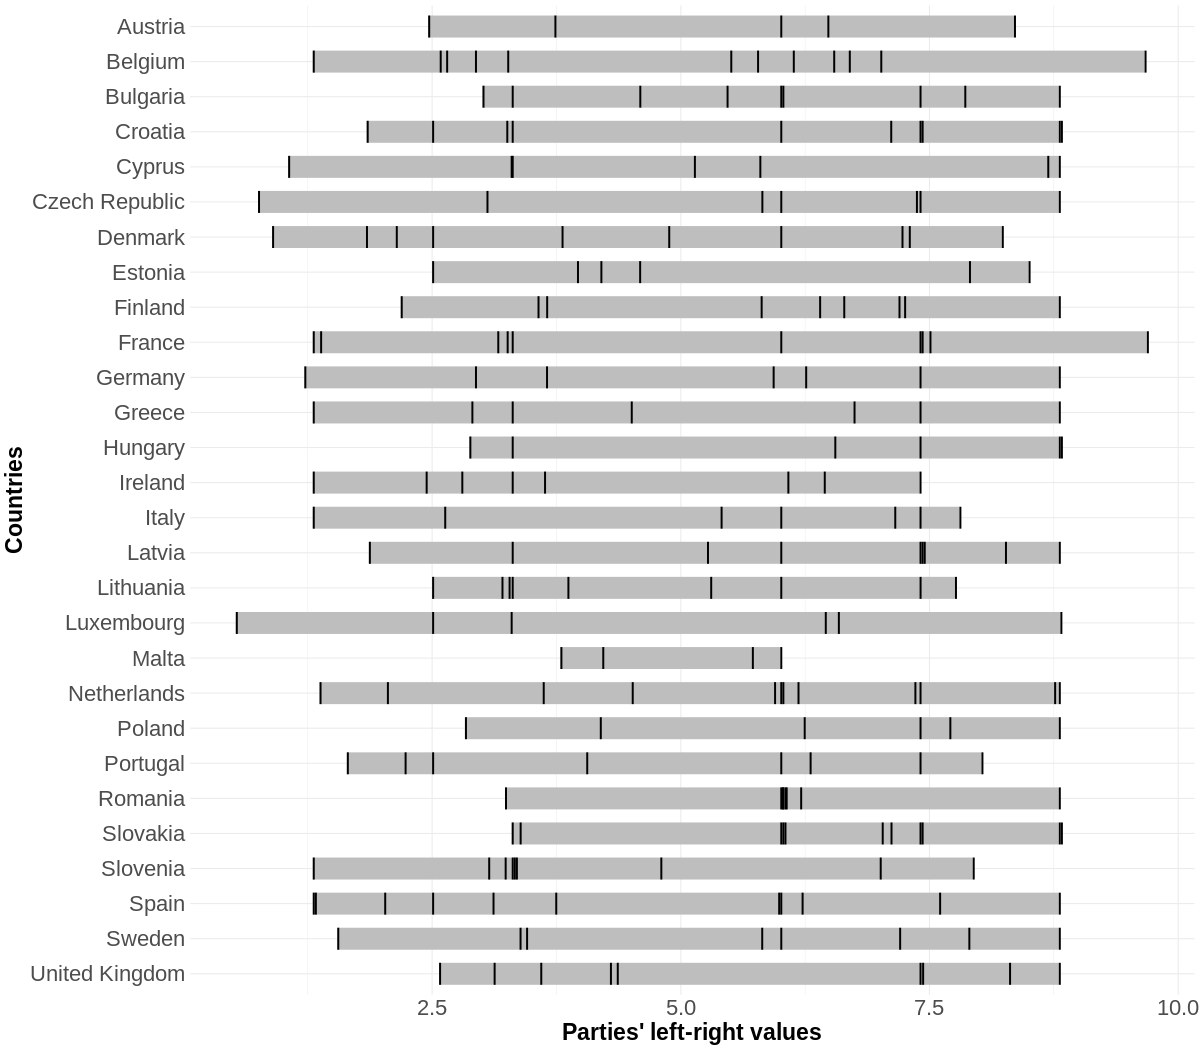

In [ ]:
%%R -w 1200 -h 1050 -u px
eu_ideologies <- eu_ideologies[order(eu_ideologies$country_name),]
eu_ideologies_to_plot <- data.table(eu_ideologies, alpha_order=c(1:28) * - 1) # this is to order alphab

myplot <- ggplot(data = eu_ideologies_to_plot)+
  geom_segment(aes(x = reorder(country_name,(alpha_order)), xend = country_name, y = min, yend = max), size = 10.3, colour = "gray", alpha = 1) + #  colour = "darkcyan", alpha = 0.7) the second variable of reorder is the variable to sort
  coord_flip() +
  xlab("Countries") +
  theme_minimal() +
  theme(axis.text=element_text(size=22),
        axis.title=element_text(size=23,face="bold"), legend.text=element_text(size=14), legend.title=element_text(size=15)) +
  ylab("Parties' left-right values")#ylab("Valores left-right de los partidos políticos")


index <- 1
country_index <- 1

for(c in cn){
    ideologies <- posts_data %>% filter(country_name==c) %>% filter(!is.na(left_right)) %>% group_by(page_id, left_right) %>% summarise(n=1,  .groups = 'drop')
    ideology_index <- 1 
    array <- c()

    for(i in ideologies$left_right){
        while(as.numeric(i) %in% array){
          print(i)
          i <- as.numeric(i) + 0.021 

        }
        array <- c(array, as.numeric(i))

        gg.data <- data.frame(country = c, ystart = i, ylast = i + 0.02)
        myplot <- myplot + geom_segment(data=gg.data, aes(x = country, xend=country, y = ystart, yend = ylast), size = 10.3, colour = "black")  #+ geom_segment(aes(x = c, xend=c, y = i-1, yend = i + 0.01), size = 5, colour = "black") 

    }
    country_index <- country_index + 1

}



print(myplot)

In [ ]:
%%R
FB_users <- read.csv("FB_users.csv", encoding="UTF8")

FB_users  <- FB_users %>% filter(country %in% cn) %>% select(country,mau_FB) %>% rename(country_name=country)

In [ ]:
%%R
summary <- posts_data %>% inner_join(FB_users, by="country_name") %>% group_by(party_name, country_name, left_right) %>% summarise(posts=length(comments), reac=median(reaction_count), comm=median(comments))
summary <- summary %>% inner_join(posts_data %>% filter(!is.na(video_views)) %>% filter(video_views!="NaN") %>% group_by(party_name) %>% summarise(views=median(video_views)), by="party_name")


`summarise()` has grouped output by 'party_name', 'country_name'. You can
override using the `.groups` argument.


In [ ]:
%%R 

cn = eu_ideologies$country_name
print(cn)
total <- 0
posts_data_c <- posts_data %>% filter(!is.na(left_right))
for(c in cn){
    print(c)
    total <- total + length(unique( (posts_data_c %>% filter(country_name==c))$page_id))
    print(length(unique( (posts_data_c %>% filter(country_name==c))$page_id)))
     print(length( (posts_data_c %>% filter(country_name==c))$page_id))
}
print(paste("Total:", total, sep=" "))

 [1] "Austria"        "Belgium"        "Bulgaria"       "Croatia"       
 [5] "Cyprus"         "Czech Republic" "Denmark"        "Estonia"       
 [9] "Finland"        "France"         "Germany"        "Greece"        
[13] "Hungary"        "Ireland"        "Italy"          "Latvia"        
[17] "Lithuania"      "Luxembourg"     "Malta"          "Netherlands"   
[21] "Poland"         "Portugal"       "Romania"        "Slovakia"      
[25] "Slovenia"       "Spain"          "Sweden"         "United Kingdom"
[1] "Austria"
[1] 5
[1] 15619
[1] "Belgium"
[1] 12
[1] 23174
[1] "Bulgaria"
[1] 9
[1] 20745
[1] "Croatia"
[1] 10
[1] 18623
[1] "Cyprus"
[1] 7
[1] 22464
[1] "Czech Republic"
[1] 7
[1] 21583
[1] "Denmark"
[1] 10
[1] 12743
[1] "Estonia"
[1] 6
[1] 14211
[1] "Finland"
[1] 9
[1] 19572
[1] "France"
[1] 10
[1] 23982
[1] "Germany"
[1] 7
[1] 13731
[1] "Greece"
[1] 7
[1] 21311
[1] "Hungary"
[1] 6
[1] 30056
[1] "Ireland"
[1] 8
[1] 12328
[1] "Italy"
[1] 7
[1] 46114
[1] "Latvia"
[1] 9
[1] 14479
[1]

In [ ]:
%%R
view_party <- read.csv("view_party.csv", encoding="UTF8")
view_party <- view_party %>% filter(country_name %in% cn)
print(head(view_party))
print(length(unique(view_party$party_id)))

  country_name_short country_name party_name_short
1                AUT      Austria              ALO
2                AUT      Austria               BD
3                AUT      Austria              BZO
4                AUT      Austria              CSA
5                AUT      Austria               DD
6                AUT      Austria              DFP
                              party_name_english
1                       Alternative List Austria
2                             Centrist Democrats
3             Alliance for the Future of Austria
4 Christian Social Alliance (Karl Habsburg List)
5                               German-Democrats
6                   Democratic Progressive Party
                                        party_name
1                    Alternative Liste Österreichs
2                           Bürgerliche Demokraten
3                       Bündnis Zukunft Österreich
4 Christlich Soziale Allianz (Liste Karl Habsburg)
5                                Deutschdemok

# Countries ideology

## Ideology by parliament elections 

### By vote share in 2019 european elections (Ground Truth)

In [ ]:
%%R 
# United Kingdom
countries <- unique(posts_data$country_name)

getLastEuropeanElection <- function(country){
    

    view_election <- read.csv("view_election.csv", encoding="UTF8")
    elections_country <- view_election %>% filter(country_name==country) %>% filter(election_type=="ep")

    elections_country <- elections_country %>% filter(as.character(as.Date(election_date), format="%Y-%m")=="2019-05")
   
    return(elections_country)

}


count <- 0

for(country in countries){
    eu_country_elections <- getLastEuropeanElection(country)
    count <- count + (length(eu_country_elections$country_name))
}

eu_elections = data.table("country_name" = 1:count, "left_right" = NA, "vote_share" = NA, "country_ideology" = NA)

index = 1
for(country in countries){
    eu_country_elections <- getLastEuropeanElection(country)
    country_parties <- eu_country_elections$party_name
    
    for(party in country_parties){
        this_party <- eu_country_elections %>% filter(party_name==party)
        eu_elections$country_name[index] <- this_party$country_name
        eu_elections$left_right[index] <- this_party$left_right
        eu_elections$vote_share[index] <- this_party$vote_share
        index <- index +1
    }
}


In [ ]:
%R eu_elections


country_name  left_right  vote_share  country_ideology
1        Croatia      7.1053       22.72       -2147483648
2        Croatia      3.2456       18.71       -2147483648
3        Croatia         NaN        7.89       -2147483648
4        Croatia      8.8000        5.66       -2147483648
5        Croatia      3.4211        5.19       -2147483648
..           ...         ...         ...               ...
288      Estonia      4.5812       12.70       -2147483648
289      Estonia      8.4962       10.30       -2147483648
290      Estonia      2.5000        1.80       -2147483648
291      Estonia      6.0000        3.20       -2147483648
292      Estonia         NaN        6.20       -2147483648

[292 rows x 4 columns]

In [ ]:
%%R

ideology_eu_elections = data.table("country_name" = countries, "ideology" = 0.2)
for(country in countries){
    country_elections <- eu_elections %>% filter(country_name==country) %>% filter(!is.na(vote_share)) %>% filter(!is.na(left_right))
    ideology_eu_elections[ideology_eu_elections$country_name==country]$ideology <- weighted.mean(country_elections$left_right, country_elections$vote_share, na.rm=TRUE) 
}

for(index in seq_along(eu_elections$country_name)){
    eu_elections$country_ideology[index] <- ideology_eu_elections[ideology_eu_elections$country_name==eu_elections$country_name[index]]$ideology
}
ideology_eu_elections_tr <- ideology_eu_elections %>% rename("ideology_by_votes" = ideology)

## Dalton

In [ ]:
%%R
#PI = SQRT{∑(party vote share(i))*([party L/R scorei – party system average L/R score]/5)²}
variable <- c(1.7,38.7,6.7,38.6,8.2)
left_right <- c(3.84,4.33,4.69,6.45,6.50)

tab <- data.table("variable"=variable, "ideology"=left_right)

variable <- c(16.43,30,40.71,12.86)

tab2 <- data.table("variable"=variable, "ideology"=left_right)
calculate_dalton <- function(tab){
    
    left_right_avg <- weighted.mean(tab$ideology, tab$variable, na.rm=TRUE)
  total_variable <- sum(tab$variable)

  sumatory <- 0
  for(i in seq(tab$var)){
      sumatory <- sumatory + (  (tab[i]$variable / total_variable * 100) * ((tab[i]$ideology-left_right_avg)/5)^2  )
  }

  return(sqrt(sumatory))

}

print(calculate_dalton(tab))
# print(calculate_dalton(tab2))

[1] 2.107798


In [ ]:
%%R
eu_elections_copy <- eu_elections
summary_table = data.table(country=unique(eu_elections_copy$country_name), real_dalton = 0)
 # simpleSubstraction = 0,
  #daltonWithFiftyFifty = 0,

for(c in summary_table$country){
  #print(country)

  countryParties <- eu_elections_copy %>% filter(country_name==c) %>% filter(!is.na(vote_share)) %>% filter(!is.na(left_right)) 


  mean_lr <- mean(countryParties$country_ideology)
  cumsum <- 0

  
  for(party in seq(countryParties$left_right)){

      cumsum <- cumsum + ((countryParties$vote_share[party])*((countryParties$left_right[party] - mean_lr)/5)^2)
  }
  summary_table[country==c]$real_dalton <- sqrt(cumsum)


}

dalton_table <- data.table("country_name"=summary_table$country, "dalton"=summary_table$real_dalton)

## Idology by number of posts (total)

In [ ]:
%%R 

get_weighted_number_by_percentage_threshold <- function(percentage, country_table){
  country_table <- copy(country_table)
  if(nrow(country_table) <= 1){
      return(0)
  }
  if(percentage != 100){
    if(percentage > 50){
        country_table <- country_table[order(-ideology)]
        percentage = 100 - percentage
    }else{
        country_table <- country_table[order(ideology)]
    }
  }

  percentage_sum <- 0
  sum <- 0
  total <- sum(country_table$variable)
  total_sum <- 0
  for(party in country_table$party_id){
      
      if(country_table[party_id==party]$variable/total == "NaN"){
          next
      }
      if(percentage_sum + country_table[party_id==party]$variable/total*100 > percentage){
        percentage_in_the_last = percentage - percentage_sum
        last_multiplier = percentage_in_the_last/(country_table[party_id==party]$variable/total*100)
        sum <- sum + (country_table[party_id==party]$variable * country_table[party_id==party]$ideology * last_multiplier)
        total_sum <- total_sum + country_table[party_id==party]$variable * last_multiplier
        break
      }else{
        percentage_sum <- percentage_sum + country_table[party_id==party]$variable/total*100
        sum <- sum + country_table[party_id==party]$variable * country_table[party_id==party]$ideology
        total_sum <- total_sum + country_table[party_id==party]$variable
      }
  }
  if(total_sum == 0){
      return(mean(country_table$ideology))
  }
  
  return(sum /total_sum)
}

get_weighted_number_by_percentage_threshold <- function(percentage, country_table){
  country_table <- copy(country_table)
  if(nrow(country_table) <= 1){
      return(0)
  }
  percentage_sum <- 0
  sum <- 0
  total <- sum(country_table$variable)
  total_sum <- 0
  for(party in country_table$party_id){
      
      if(country_table[party_id==party]$variable/total == "NaN"){
          next
      }

      percentage_sum <- percentage_sum + country_table[party_id==party]$variable/total*100
      sum <- sum + country_table[party_id==party]$variable * country_table[party_id==party]$ideology
      total_sum <- total_sum + country_table[party_id==party]$variable
      
  }
  if(total_sum == 0){
      return(mean(country_table$ideology))
  }
  
  return(sum /total_sum)
}


In [ ]:
%%R -w 1000 -h 350 -u px

get_ideo_posts <- function(){
    to_plot_ideology_p <<- posts_data_act[,list(posts=length(comments)), by="page_id,post_id,country_name,left_right"]
    to_plot_ideology_p <<- to_plot_ideology_p %>% filter(!is.na(left_right))

    ideology_by_number_posts <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)

    for(country in countries){
        country_posts <- to_plot_ideology_p %>% filter(country_name == country)
        country_posts_divided_by_parties <- data.table("party_id" = unique(country_posts$page_id), "variable" = 0.1, "ideology" = 0.1)

        for(party in unique(country_posts$page_id)){
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$variable <- length(country_posts[page_id==party]$post_id)
     
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$ideology <- country_posts[page_id==party]$left_right[1]
        }

        ideology_by_number_posts[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties)
        ideology_by_number_posts[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties)

    }

  country_ideology_by_number_posts_mean <<- ideology_by_number_posts
}

get_ideo_posts()


## Ideology by number of posts (posts / day)

In [ ]:
%%R
prepare_posts_day_data <- function(){
    
  posts_data_freq <- posts_data_act
  posts_data_freq <- data.table(posts_data_freq)
  posts_data_freq <- posts_data_freq[order(posts_data_freq$timestamp)]

  parties = unique(posts_data_freq$page_id)

  for(party_index in parties){
    party = posts_data_freq[posts_data_freq$page_id==party_index]
    array = c()

    for(index in 2:length(party$page_id)){
      pre_date = as.POSIXct(party$timestamp[index-1])
      post_date = as.POSIXct(party$timestamp[index])
      diff = difftime(post_date, pre_date, units="day")
      array[index - 1] <- diff
    }
      posts_data_freq$time_dif[posts_data_freq$page_id==party_index] <- 1/median(array)

      if(is.na(1/median(array))){
          posts_data_freq$time_dif[posts_data_freq$page_id==party_index] <- 0
      }
  }

  posts_data_freq <- posts_data_freq[,list(posts=length(comments)), by="page_id,left_right,country_name,time_dif"] %>% group_by(page_id) %>% filter (posts > 4)
  posts_data_freq <<- posts_data_freq
}

prepare_posts_day_data()

In [ ]:
%%R

get_ideo_posts_per_day <- function(percentage){ 

  ideology_by_posts_per_day <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
  posts_per_day_info<- data.table("country_name" = countries, "mean"=0.1, "median"=0.1, "posts_per_day"=0.1)
  for(country in countries){
 
      country_posts <- data.table(posts_data_freq %>% filter(country_name==country) %>% filter(!is.na(left_right)))
      country_posts_divided_by_parties <- data.table("party_id" = unique(country_posts$page_id), "variable" = 0.1, "ideology" = 0.1)

      for(party in unique(country_posts$page_id)){
          country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$variable <- country_posts[page_id==party]$time_dif
          country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$ideology <- country_posts[page_id==party]$left_right
      }

      ideology_by_posts_per_day[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties)
      ideology_by_posts_per_day[country_name == country]$polarization <- calculate_dalton(country_posts_divided_by_parties)

      posts_per_day_info[country_name==country]$mean <- mean(country_posts_divided_by_parties$variable)
      posts_per_day_info[country_name==country]$median <- median(country_posts_divided_by_parties$variable)
      posts_per_day_info[country_name==country]$posts_per_day <- sd(country_posts_divided_by_parties$variable)

  }
  ideology_by_posts_per_day <<- ideology_by_posts_per_day
  posts_per_day_info <<- posts_per_day_info
  
}

get_ideo_posts_per_day()

## Ideology by number of Followers


In [ ]:
%%R

get_ideo_followers <- function(percentage){
    page_data = posts_data_act[,list(shares=sum(shares)),by="page_id,country_name,left_right"]
    page_data <- page_data %>% filter(!is.na(left_right))

    fb_followers <- read.csv("FB_followers.csv", encoding="UTF8")
    fb_followers <- data.table(fb_followers)

    ideology_by_followers <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)

    for(country in countries){
        country_pages <- page_data %>% filter(country_name==country)
        country_posts_divided_by_parties <- data.table("party_id" = unique(country_pages$page_id), "variable" = 0.1, "ideology" = 0.1)

        for(page in seq_along(country_pages$page_id)){
            current_page = country_pages[page]$page_id
            current_ideology = country_pages[page]$left_right

            followers <- fb_followers[fb_followers$page_id==current_page]$followers

            if(length(followers)==0){
                print(paste(current_page))
                next
            }
            if(is.na(followers)){
                followers = 0
            }
            party <- current_page

            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$variable <- followers
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$ideology <- current_ideology

        }

        ideology_by_followers[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties)
        ideology_by_followers[country_name == country]$polarization <- calculate_dalton(country_posts_divided_by_parties)

    }
  ideology_by_followers <<- ideology_by_followers


  fb_followers <<- fb_followers
}

get_ideo_followers()

[1] "353195602108"
[1] "100064451152064"


## Ideology by number of page likes

In [ ]:
%%R

get_ideo_pagelikes <- function(percentage){
    page_data = posts_data_act[,list(shares=sum(shares)),by="page_id,country_name,left_right"]
    page_data <- page_data %>% filter(!is.na(left_right))

    ideology_by_page_likes <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)

    for(country in countries){
        country_pages <- page_data %>% filter(country_name==country)

        country_posts_divided_by_parties <- data.table("party_id" = unique(country_pages$page_id), "variable" = 0.1, "ideology" = 0.1)
        for(page in seq_along(country_pages$page_id)){
            current_page = country_pages[page]$page_id
            current_ideology = country_pages[page]$left_right

            likes <- fb_followers[fb_followers$page_id==current_page]$likes

            if(length(likes) == 0){
                next
            }
            if(is.na(likes)){
                likes = 0
            }

            party <- current_page

            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$variable <- likes
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$ideology <- current_ideology

        }

    ideology_by_page_likes[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties)
    ideology_by_page_likes[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties)
  }
  ideology_by_page_likes <<- ideology_by_page_likes

}
get_ideo_pagelikes()


## Ideologies by posts and days/weeks


In [ ]:
%%R

get_ideologies_by_posts <- function(){


  to_plot_ideology_p <- posts_data_act[,list(shares=shares, comments=comments, views=video_views, reactions=reaction_count), by="page_id,post_id,country_name,left_right"]
  to_plot_ideology_p <- to_plot_ideology_p %>% filter(!is.na(left_right))

	
	ideology_by_reactions <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
	ideology_by_reactions_median <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
	ideology_by_reactions_mean <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
	
	ideology_by_comments <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
	ideology_by_comments_median <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
	ideology_by_comments_mean <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
	
	ideology_by_shares <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
  ideology_by_shares_median <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
	ideology_by_shares_mean <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
	
	ideology_by_video_views <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
  ideology_by_video_views_median <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
	ideology_by_video_views_mean <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)

    for(country in countries){
        country_posts <- to_plot_ideology_p %>% filter(country_name==country)
         country_posts_divided_by_parties <- data.table( CJ("party_id" = unique(country_posts$page_id), "variable" = 0.1, 
          "feature" = c("reac", "reac_median", "reac_mean", "comm", "comm_median", "comm_mean", "sh", "sh_median", "sh_mean", "views", "views_median", "views_mean")),
           "ideology" = 0.1)

        for(party in unique(country_posts$page_id)){
            party_posts <- country_posts %>% filter(page_id==party)

            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="reac"]$variable <- sum(party_posts$reactions)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="reac_median"]$variable <- median(party_posts$reactions)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="reac_mean"]$variable <- mean(party_posts$reactions)

            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="comm"]$variable <- sum(party_posts$comments)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="comm_median"]$variable <- median(party_posts$comments)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="comm_mean"]$variable <- mean(party_posts$comments)

            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="sh"]$variable <- sum(party_posts$shares)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="sh_median"]$variable <- median(party_posts$shares)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="sh_mean"]$variable <- mean(party_posts$shares)

            party_posts_views <- party_posts %>% filter(!is.na(views)) %>% filter(views != "NaN")

            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="views"]$variable <- sum(party_posts_views$views)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="views_median"]$variable <- median(party_posts_views$views)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="views_mean"]$variable <- mean(party_posts_views$views)

            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$ideology <- party_posts$left_right[1]
    
        }

        ######################################################
        ######### Country Ideology ###########################
        ######################################################

        ideology_by_reactions[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="reac"))
        ideology_by_reactions_median[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="reac_median"))
        ideology_by_reactions_mean[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="reac_mean"))

        ideology_by_comments[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="comm"))
        ideology_by_comments_median[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="comm_median"))
        ideology_by_comments_mean[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="comm_mean"))
 
        ideology_by_shares[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="sh"))
        ideology_by_shares_median[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="sh_median"))
        ideology_by_shares_mean[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="sh_mean"))
        
        ideology_by_video_views[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="views") %>% filter(!is.na(variable)))
        ideology_by_video_views_median[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="views_median") %>% filter(!is.na(variable)))
        ideology_by_video_views_mean[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="views_mean") %>% filter(!is.na(variable)))


        ######################################################
        ######### Dalton Polarization ########################
        ######################################################
        
        ideology_by_reactions[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="reac"))
        ideology_by_reactions_median[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="reac_median"))
        ideology_by_reactions_mean[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="reac_mean"))

        ideology_by_comments[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="comm"))
        ideology_by_comments_median[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="comm_median"))
        ideology_by_comments_mean[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="comm_mean"))
 
        ideology_by_shares[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="sh"))
        ideology_by_shares_median[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="sh_median"))
        ideology_by_shares_mean[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="sh_mean"))
        
        ideology_by_video_views[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="views") %>% filter(!is.na(variable)))
        ideology_by_video_views_median[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="views_median") %>% filter(!is.na(variable)))
        ideology_by_video_views_mean[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="views_mean") %>% filter(!is.na(variable)))


    }
    ideology_by_reactions <<- ideology_by_reactions
    ideology_by_reactions_median <<- ideology_by_reactions_median
    ideology_by_reactions_mean <<- ideology_by_reactions_mean

    ideology_by_comments <<- ideology_by_comments
    ideology_by_comments_median <<- ideology_by_comments_median
    ideology_by_comments_mean <<- ideology_by_comments_mean

    ideology_by_shares <<- ideology_by_shares
    ideology_by_shares_median <<- ideology_by_shares_median
    ideology_by_shares_mean <<- ideology_by_shares_mean

    ideology_by_video_views <<- ideology_by_video_views
    ideology_by_video_views_median <<- ideology_by_video_views_median
    ideology_by_video_views_mean <<- ideology_by_video_views_mean

}

get_ideologies_by_posts()

In [ ]:
%%R

get_ideologies_median_day_week <- function(percentage){

    to_plot_ideology_p = posts_data_act[,list(shares=shares, comments=comments, views=video_views,reactions=reaction_count), by="page_id,post_id,country_name,left_right,timestamp,week"]
    to_plot_ideology_p <- to_plot_ideology_p %>% filter(!is.na(left_right))

    ideology_by_reactions_median_day = data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
    ideology_by_comments_median_day = data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
    ideology_by_shares_median_day = data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
    ideology_by_video_views_median_day = data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)

    ideology_by_reactions_median_week = data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
    ideology_by_comments_median_week = data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
    ideology_by_shares_median_week = data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
    ideology_by_video_views_median_week = data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)

	
    for(country in countries){
        country_posts <- to_plot_ideology_p %>% filter(country_name==country)
        country_posts_divided_by_parties <- data.table(CJ("party_id" = unique(country_posts$page_id), "variable" = 0.1, 
                                                          "feature"=c("reac_d", "comm_d", "sh_d", "views_d", "reac_w", "comm_w", "sh_w", "views_w")), "ideology" = 0.1)


        for(party in unique(country_posts$page_id)){
            party_posts <- country_posts %>% filter(page_id==party)
            party_posts$timestamp <- str_split(party_posts$timestamp, " ", simplify=TRUE)[,1] # Gets only the day of the post

      
            party_posts_by_days <- party_posts %>% group_by(timestamp) %>% summarise(reactions=sum(reactions), comments=sum(comments), shares=sum(shares))
            party_posts_by_weeks <- party_posts %>% group_by(week) %>% summarise(reactions=sum(reactions), comments=sum(comments), shares=sum(shares))

            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="reac_d"]$variable <- median(party_posts_by_days$reactions)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="comm_d"]$variable <- median(party_posts_by_days$comments)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="sh_d"]$variable <- median(party_posts_by_days$shares)

            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="reac_w"]$variable <- median(party_posts_by_weeks$reactions)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="comm_w"]$variable <- median(party_posts_by_weeks$comments)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="sh_w"]$variable <- median(party_posts_by_weeks$shares)


            party_posts_with_videos <- party_posts %>% filter(!is.na(views)) %>% filter(views != "NaN")

            party_posts_by_days <- party_posts %>% group_by(timestamp) %>% summarise(views=sum(views, na.rm = TRUE))
            party_posts_by_days <- party_posts_by_days %>% filter(views > 0)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="views_d"]$variable <- median(party_posts_by_days$views)

            party_posts_by_weeks <- party_posts %>% group_by(week) %>% summarise(views=sum(views, na.rm = TRUE))
            party_posts_by_weeks <- party_posts_by_weeks %>% filter(views > 0)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="views_w"]$variable <- median(party_posts_by_weeks$views)
            
			      country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$ideology <- party_posts$left_right[1]

        }
        ideology_by_reactions_median_day[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="reac_d"))
        ideology_by_comments_median_day[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="comm_d"))
        ideology_by_shares_median_day[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="sh_d"))
        ideology_by_video_views_median_day[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="views_d") %>% filter(!is.na(variable)))
        
        ideology_by_reactions_median_week[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="reac_w"))
        ideology_by_comments_median_week[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="comm_w"))
        ideology_by_shares_median_week[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="sh_w"))
        ideology_by_video_views_median_week[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="views_w") %>% filter(!is.na(variable)))



        ideology_by_reactions_median_day[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="reac_d"))
        ideology_by_comments_median_day[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="comm_d"))
        ideology_by_shares_median_day[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="sh_d"))
        ideology_by_video_views_median_day[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="views_d") %>% filter(!is.na(variable)))
        
        ideology_by_reactions_median_week[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="reac_w"))
        ideology_by_comments_median_week[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="comm_w"))
        ideology_by_shares_median_week[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="sh_w"))
        ideology_by_video_views_median_week[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="views_w") %>% filter(!is.na(variable)))
   

    }

    ideology_by_reactions_median_day <<- ideology_by_reactions_median_day
    ideology_by_comments_median_day <<- ideology_by_comments_median_day
    ideology_by_shares_median_day <<- ideology_by_shares_median_day
    ideology_by_video_views_median_day <<- ideology_by_video_views_median_day

    ideology_by_reactions_median_week <<- ideology_by_reactions_median_week
    ideology_by_comments_median_week <<- ideology_by_comments_median_week
    ideology_by_shares_median_week <<- ideology_by_shares_median_week
    ideology_by_video_views_median_week <<- ideology_by_video_views_median_week


}

get_ideologies_median_day_week()

# Simple comparations

Comparations between the ground truth (ideology by vote shares) and the ideology obtained get by several metrics

In [ ]:
%%R
get_new_ideology_matrix<- function(first_col, type){

  ideology_matrix = merge(x = first_col, y = country_ideology_by_number_posts_mean %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "posts")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_posts_per_day %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "posts_per_day")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_reactions %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "reactions")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_reactions_median %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "reactions_median")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_reactions_mean %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "reactions_mean")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_reactions_median_day %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "reactions_median_day")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_reactions_median_week %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "reactions_median_week")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_shares %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "shares")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_shares_median %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "shares_median")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_shares_mean %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "shares_mean")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_shares_median_day %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "shares_median_day")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_shares_median_week %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "shares_median_week")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_comments %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "comments")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_comments_median %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "comments_median")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_comments_mean %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "comments_mean")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_comments_median_day %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "comments_median_day")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_comments_median_week %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "comments_median_week")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_video_views %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "video_views")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_video_views_median %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "video_views_median")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_video_views_mean %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "video_views_mean")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_video_views_median_day %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "video_views_median_day")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_video_views_median_week %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "video_views_median_week")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_followers %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "followers")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_page_likes %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "page_likes")

  return(ideology_matrix)
}

ideo_matrix <- get_new_ideology_matrix(ideology_eu_elections_tr, "ideology")
pol_matrix <- get_new_ideology_matrix(dalton_table, "polarization")

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(type)` instead of `type` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


In [ ]:
%%R

reload_all_data <- function(initial_date, final_date, country_to_filter){

  c_name_to_filter <- "none.csv"
  if(!missing(country_to_filter)){
      c_name_to_filter <- paste(country_to_filter, "csv", sep=".")
  }

  filename_ide <- paste("ideo",initial_date,final_date,c_name_to_filter, sep="_")
  filename_pol <- paste("pol",initial_date,final_date,c_name_to_filter, sep="_")

  if(file.exists(filename_ide)){
       ideo_matrix <<- fread(filename_ide)
       pol_matrix <<- fread(filename_pol)
  }else{
    load_initial_data(initial_date, final_date, country_to_filter)

    get_ideo_posts()
    #prepare_posts_day_data()
    get_ideo_posts_per_day()

    get_ideologies_median_day_week()
    get_ideologies_by_posts()

    get_ideo_followers()
    get_ideo_pagelikes()
    
    
    pol_matrix <<- get_new_ideology_matrix(dalton_table, "polarization")
    ideo_matrix <<- get_new_ideology_matrix(ideology_eu_elections_tr, "ideology")

    fwrite(pol_matrix, filename_pol)
    fwrite(ideo_matrix, filename_ide)

  }
}

In [ ]:
%%R 
#reload_all_data("2018-12-31", "2019-05-21")
reload_all_data("2018-12-31", "2019-01-10")


[1] "Total posts wihtout filters: 597200"
[1] "Total posts with date filters: 1835"
[1] "353195602108"
[1] "100064451152064"


## Load data

In [ ]:
%%R

get_variables_to_compare <- function(ideology_m){
  variables_to_compare = list(
    ideology_m$posts,
    ideology_m$posts_per_day,
    ideology_m$reactions,
    ideology_m$reactions_median,
    ideology_m$reactions_mean,
    ideology_m$reactions_median_day,
    ideology_m$reactions_median_week,
    ideology_m$shares,
    ideology_m$shares_median,
    ideology_m$shares_mean,
    ideology_m$shares_median_day,
    ideology_m$shares_median_week,
    ideology_m$comments,
    ideology_m$comments_median,
    ideology_m$comments_mean,
    ideology_m$comments_median_day,
    ideology_m$comments_median_week,
    ideology_m$video_views,
    ideology_m$video_views_median,
    ideology_m$video_views_mean,
    ideology_m$video_views_median_day,
    ideology_m$video_views_median_week,
    ideology_m$followers,
    ideology_m$page_likes
  )

  return(variables_to_compare)
}

variables_to_compare <- get_variables_to_compare(pol_matrix)


  names_ <- c(
      "posts",
      "posts_per_day",
      "reactions",
      "reactions_median",
      "reactions_mean",
      "reactions_median_day",
      "reactions_median_week",
      "shares",
      "shares_median",
      "shares_mean",
      "shares_median_day",
      "shares_median_week",
      "comments",
      "comments_median",
      "comments_mean",
      "comments_median_day",
      "comments_median_week",
      "video_views",
      "video_views_median",
      "video_views_mean",
      "video_views_median_day",
      "video_views_median_week",
      "followers",
      "page_likes"
  )

# Training with different time windows


## Linear Models

In [ ]:
%%R

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}


In [ ]:
%%R 
months <- c(0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 4.75)

get_r2_p_values <- function(matrix_type, ground_tr){
  best_r2 <- 0
  variables_to_comp <- get_variables_to_compare(pol_matrix)

    r2_values = matrix(1:length(variables_to_comp)^2, nrow=length(variables_to_comp), dimnames = list(names_,names_))
    p_values = matrix(1:length(variables_to_comp)^2, nrow=length(variables_to_comp), dimnames = list(names_,names_))
    months_matrix = matrix(1:length(variables_to_comp)^2, nrow=length(variables_to_comp), dimnames = list(names_,names_))

    for(index in seq(variables_to_comp)){
      for(index2 in seq(variables_to_comp)){
            p_values[index,index2] <- 0
            r2_values[index,index2] <- 0
            months_matrix[index,index2] <- 0
      }
    }

    for(m in months){
      print(paste(matrix_type, m))
      reload_all_data(as.Date("2019-05-21") - 30 * m, as.Date("2019-05-21"))
      variables_to_comp <- get_variables_to_compare(get(matrix_type))
      truth <- unlist(get(matrix_type)
       %>% select(ground_tr))
  


      # Setting alpha = 1 implements lasso regression
      x <- data.matrix(get(matrix_type) %>% select(-ground_tr) %>% select(-country_name))

      # x = data.matrix(x)
      y_train = truth

      lambdas <- 10^seq(2, -3, by = -.1)

      ridge_reg = glmnet(x, y_train, alpha = 1, family = 'gaussian')

      MSEs <- NULL
      for (i in 1:100){
          cv <- cv.glmnet(x, y_train, alpha = 1, family = 'gaussian')
          MSEs <- cbind(MSEs, cv$cvm)
      }

      rownames(MSEs) <- cv$lambda
      lambda.min <- as.numeric(names(which.min(rowMeans(MSEs))))



      eval_results <- function(true, predicted, df) {
        SSE <- sum((predicted - true)^2)
        SST <- sum((true - mean(true))^2)
        R_square <- 1 - SSE / SST
        RMSEv = sqrt(SSE/nrow(df))

        # Model performance metrics
        print(paste(R_square, RMSE(true, predicted)))
        R_square
    }

    # Prediction and evaluation on train data
    print(coef(ridge_reg, s=lambda.min))
    predictions_train <- predict(ridge_reg, x, s=lambda.min)

    r2 <- (eval_results(y_train, predictions_train, train))
      if(r2 > best_r2){
          best_r2 <- r2
          best_fit <- ridge_reg
          best_lambda <- lambda.min
          best_m <- m
      }
    }
    return_list <- list(best_r2,best_fit,best_lambda, best_m)
    return(return_list)
}




In [ ]:
%%R
best_ideo_model <- get_r2_p_values("ideo_matrix", "ideology_by_votes")
ideo_model <- best_ideo_model[[2]]
ideo_lambda <- best_ideo_model[[3]]
print(paste( best_ideo_model[[1]],  best_ideo_model[[4]]))

[1] "ideo_matrix 0.25"
25 x 1 sparse Matrix of class "dgCMatrix"
                                s1
(Intercept)             2.38402243
posts                   0.26809239
posts_per_day           0.11524541
reactions               .         
reactions_median        0.04920582
reactions_mean          .         
reactions_median_day    .         
reactions_median_week   .         
shares                  .         
shares_median           .         
shares_mean             .         
shares_median_day       .         
shares_median_week      .         
comments                .         
comments_median         .         
comments_mean           .         
comments_median_day     .         
comments_median_week    .         
video_views             .         
video_views_median      .         
video_views_mean        .         
video_views_median_day  .         
video_views_median_week .         
followers               .         
page_likes              0.12987810
[1] "0.769672138400906 0.

In [ ]:
%%R
best_pol_model <- get_r2_p_values("pol_matrix", "dalton")
pol_mode <- best_pol_model[[2]]
pol_lambda <- best_pol_model[[3]]
print(paste( best_pol_model[[1]],  best_pol_model[[4]]))

[1] "pol_matrix 0.25"
25 x 1 sparse Matrix of class "dgCMatrix"
                                 s1
(Intercept)             1.464670816
posts                   .          
posts_per_day           0.119506965
reactions               0.036382387
reactions_median        .          
reactions_mean          .          
reactions_median_day    .          
reactions_median_week   .          
shares                  .          
shares_median           .          
shares_mean             .          
shares_median_day       .          
shares_median_week      .          
comments                .          
comments_median         .          
comments_mean           .          
comments_median_day     .          
comments_median_week    .          
video_views             .          
video_views_median      0.001416315
video_views_mean        0.118553598
video_views_median_day  0.123335850
video_views_median_week .          
followers               .          
page_likes              0.224921646


# Validation with parliament elections


In [ ]:
%%R

ideology_percentage <- function(election, percentage){
    total_vote_share <- 0
    ideology_percentage <- 0

  

    if(percentage > sum(election$vote_share)){
        percentage = sum(election$vote_share)
    }

    for(index in seq(election$left_right)){
      if(total_vote_share + election$vote_share[index] > percentage){
          to_add = percentage - total_vote_share
          
      }else{
          to_add = election$vote_share[index]
      }
      total_vote_share <- total_vote_share + to_add
      
      ideology_percentage <- ideology_percentage + election$left_right[index] * to_add / percentage
      
      if(total_vote_share >= percentage){
          break
      }
      
    }
  return(ideology_percentage)
}

In [ ]:
%%R 

getParliamentElection <- function(country, elec){

    view_election <- read.csv("view_election.csv", encoding="UTF8")
    elections_country <- view_election %>% filter(country_name==country) %>% filter(election_type=="parliament")

    elections_country <- elections_country %>% filter(as.character(as.Date(election_date), format="%Y-%m-%d")==elec)
   
    return(elections_country)

}
elect <- getParliamentElection("Spain", "2019-11-10") %>% filter(!is.na(left_right)) %>% filter(!is.na(vote_share))
elect <- elect[order(-elect$left_right),]

print(ideology_percentage(elect, 100))
print(weighted.mean(elect$left_right, elect$vote_share, na.rm=TRUE) )

[1] 5.270574
[1] 5.270574


## Time analysis with fitting the model with the best month fit 



In [ ]:
%%R
countries_with_elections = c("Austria", "Belgium", "Croatia", "Finland", "Estonia", "Denmark", "Spain", "United Kingdom", "Greece", "Ireland", "Lithuania", "Poland", "Portugal", "Romania", "Slovakia" )
countries_ideology <- pol_matrix %>% filter((country_name) %in% (countries_with_elections))
countries_ideology_copy <- countries_ideology

In [ ]:
%%R

view_election <- read.csv("view_election.csv", encoding="UTF8")

evaluate_parliament_elections <- function(model, lambda, matrix_variable, ground_tr="ideology_by_votes"){
    
  r2_mse_information_M <- data.table("country"=countries_with_elections, "RMSE"=0, "Prediction"=0, "Real"=0)

  print("Loading countries")
  for(coun in countries_with_elections){
      election_date = as.Date(unique((view_election %>% filter(country_name == coun) %>% filter(election_type=="parliament") %>% arrange(election_date))$election_date) %>% last())
      print(paste(coun,election_date))

      parliament_election <- getParliamentElection(coun, election_date) %>% filter(!is.na(left_right)) %>% filter(!is.na(vote_share))
      parliament_election <- parliament_election[order(parliament_election$left_right),]

      reload_all_data(election_date - 30 * m - 2, election_date - 2, coun)
      country_prediction <- predict(model, data.matrix(get(matrix_variable)[get(matrix_variable)$country_name==coun] %>% select(-ground_tr) %>% select(-country_name)), s=lambda)

      if(matrix_variable=="pol_matrix"){
        country_truth <- calculate_dalton(data.table("ideology"=parliament_election$left_right, "variable"=parliament_election$vote_share))  
      }else{
        country_truth <- ideology_percentage(parliament_election,100)
      }  

      r2_mse_information_M[country==coun]$RMSE <- RMSE(country_prediction[[1]],country_truth)
      r2_mse_information_M[country==coun]$Prediction <- country_prediction[[1]]
      r2_mse_information_M[country==coun]$Real <- country_truth
  }
  print(" --- Model results: ---")

  print(paste("RMSE:",RMSE(r2_mse_information_M$Prediction, r2_mse_information_M$Real)))
  print(paste("R2",R2(r2_mse_information_M$Prediction, r2_mse_information_M$Real)))
  return(r2_mse_information_M[order(country)])

}

### Dalton polarization


In [ ]:
%%R
print(coef( best_pol_model[[2]], s= best_pol_model[[3]]))

25 x 1 sparse Matrix of class "dgCMatrix"
                                 s1
(Intercept)              1.08272698
posts                    .         
posts_per_day            0.07648722
reactions                0.11396280
reactions_median         0.28914113
reactions_mean           .         
reactions_median_day     .         
reactions_median_week    .         
shares                   0.01339832
shares_median            .         
shares_mean              .         
shares_median_day        .         
shares_median_week       .         
comments                 .         
comments_median         -0.17764914
comments_mean            .         
comments_median_day      .         
comments_median_week     0.24684151
video_views              .         
video_views_median       .         
video_views_mean         .         
video_views_median_day   .         
video_views_median_week  .         
followers                .         
page_likes               0.12555404


In [ ]:
%%R

print("Loading data to fit the polarization lm model")
m =  best_pol_model[[4]]
print(m)
r2_mse_information_pol <- evaluate_parliament_elections( best_pol_model[[2]],  best_pol_model[[3]],"pol_matrix", "dalton")

[1] "Loading data to fit the polarization lm model"
[1] 0.5
[1] "Loading countries"
[1] "Austria 2019-09-29"
[1] "Belgium 2019-05-26"
[1] "Croatia 2020-07-05"
[1] "Finland 2019-04-14"
[1] "Estonia 2019-03-03"
[1] "Denmark 2019-06-05"
[1] "Spain 2019-11-10"
[1] "United Kingdom 2019-12-12"
[1] "Greece 2019-07-07"
[1] "Ireland 2020-02-08"
[1] "Lithuania 2020-10-11"
[1] "Poland 2019-10-13"
[1] "Portugal 2019-10-06"
[1] "Romania 2020-12-06"
[1] "Slovakia 2020-02-29"
[1] " --- Model results: ---"
[1] "RMSE: 0.338147742766966"
[1] "R2 0.752434469271545"


In [ ]:
%R r2_mse_information_pol

country      RMSE  Prediction      Real
1          Austria  0.211277    4.139055  3.927778
2          Belgium  0.327222    4.677499  5.004721
3          Croatia  0.109114    4.493693  4.384579
4          Denmark  0.040611    4.706870  4.666260
5          Estonia  0.900860    2.985139  3.885999
6          Finland  0.109167    3.594415  3.485248
7           Greece  0.125063    4.246204  4.371267
8          Ireland  0.278509    3.366980  3.645488
9        Lithuania  0.664606    3.272941  3.937547
10          Poland  0.014660    3.368112  3.382772
11        Portugal  0.011625    3.615868  3.627493
12         Romania  0.113901    3.250045  3.363947
13        Slovakia  0.090671    3.629065  3.719736
14           Spain  0.130971    5.325659  5.194688
15  United Kingdom  0.390919    3.838358  3.447440

### Country Ideology

In [ ]:
%%R
coef(ideo_model, s=ideo_lambda)

25 x 1 sparse Matrix of class "dgCMatrix"
                                 s1
(Intercept)             2.153661971
posts                   0.328168828
posts_per_day           0.040113227
reactions               .          
reactions_median        0.088896705
reactions_mean          .          
reactions_median_day    .          
reactions_median_week   .          
shares                  .          
shares_median           .          
shares_mean             .          
shares_median_day       .          
shares_median_week      .          
comments                .          
comments_median         .          
comments_mean           0.005268904
comments_median_day     .          
comments_median_week    .          
video_views             .          
video_views_median      .          
video_views_mean        .          
video_views_median_day  .          
video_views_median_week .          
followers               .          
page_likes              0.142732740


In [ ]:
%%R

print("Loading data to fit the ideology lm model")
m =  best_ideo_model[[4]]
print(m)
r2_mse_information_ideo <- evaluate_parliament_elections( best_ideo_model[[2]],  best_ideo_model[[3]],"ideo_matrix", "ideology_by_votes")

[1] "Loading data to fit the ideology lm model"
[1] 0.5
[1] "Loading countries"
[1] "Austria 2019-09-29"
[1] "Belgium 2019-05-26"
[1] "Croatia 2020-07-05"
[1] "Finland 2019-04-14"
[1] "Estonia 2019-03-03"
[1] "Denmark 2019-06-05"
[1] "Spain 2019-11-10"
[1] "United Kingdom 2019-12-12"
[1] "Greece 2019-07-07"
[1] "Ireland 2020-02-08"
[1] "Lithuania 2020-10-11"
[1] "Poland 2019-10-13"
[1] "Portugal 2019-10-06"
[1] "Romania 2020-12-06"
[1] "Slovakia 2020-02-29"
[1] " --- Model results: ---"
[1] "RMSE: 0.264253792210626"
[1] "R2 0.789209042583204"


In [ ]:
%R r2_mse_information_ideo

country      RMSE  Prediction      Real
1          Austria  0.088283    5.424062  5.512346
2          Belgium  0.300211    5.624616  5.324405
3          Croatia  0.133156    5.760656  5.893812
4          Denmark  0.199805    5.060240  5.260045
5          Estonia  0.506789    5.335253  5.842042
6          Finland  0.296575    5.650057  5.353482
7           Greece  0.012941    4.794185  4.781244
8          Ireland  0.003264    4.586255  4.582991
9        Lithuania  0.132576    5.150038  5.282613
10          Poland  0.091037    6.260262  6.351300
11        Portugal  0.128315    4.451739  4.580054
12         Romania  0.451601    5.892173  5.440572
13        Slovakia  0.347885    6.116726  6.464610
14           Spain  0.243654    5.026920  5.270574
15  United Kingdom  0.072731    5.649023  5.721755

In [ ]:
%R r2_mse_information_ideo %>% mutate(ideoRMSE=round(RMSE,3), ideoPred=round(Prediction,3), ideoReal=round(Real,3)) %>% select(country, ideoReal, ideoPred, ideoRMSE) %>% left_join(r2_mse_information_pol %>% mutate(polRMSE=round(RMSE,3),polPred=round(Prediction,3), polReal=round(Real,3)) %>% select(country, polReal, polPred,polRMSE))

Joining, by = "country"


country  ideoReal  ideoPred  ideoRMSE  polReal  polPred  polRMSE
1          Austria     5.512     5.435     0.078    3.928    4.139    0.211
2          Belgium     5.324     5.641     0.316    5.005    4.677    0.327
3          Croatia     5.894     5.755     0.139    4.385    4.494    0.109
4          Denmark     5.260     5.051     0.209    4.666    4.707    0.041
5          Estonia     5.842     5.267     0.575    3.886    2.985    0.901
6          Finland     5.353     5.592     0.239    3.485    3.594    0.109
7           Greece     4.781     4.813     0.032    4.371    4.246    0.125
8          Ireland     4.583     4.644     0.061    3.645    3.367    0.279
9        Lithuania     5.283     5.059     0.224    3.938    3.273    0.665
10          Poland     6.351     6.154     0.197    3.383    3.368    0.015
11        Portugal     4.580     4.407     0.173    3.627    3.616    0.012
12         Romania     5.441     5.808     0.368    3.364    3.250    0.114
13        Slovakia     6.465     6.111     0.354    3.720    3.629    0.091
14           Spain     5.271     4.960     0.310    5.195    5.326    0.131
15  United Kingdom     5.722     5.623     0.098    3.447    3.838    0.391